# Logistic Regression

## Bryant McArthur

## Math 403

## November 8, 2022

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [113]:
class LogiReg():
    """ input:
        y: nparray(n, 1) taking values only in {0,1}
        X: nparray(n, d)
    """
    
    def __init__(self, y, X):
        """
        Save y and X as attributes.
        """
        self.y = y
        self.X = np.column_stack((np.ones(len(y)),X))
    
    
    def fit(self):
        """
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        
        f = lambda b: np.sum(np.array([self.y[i]*np.log(1+np.exp(-self.X[i].T@b)) + (1-self.y[i])*np.log(1+np.exp(self.X[i].T@b)) for i in range(len(y))]))
        
        # Unique minimizer exists because f is convex
        beta = minimize(f, np.ones((len(self.X[0]))))
        
        self.beta = beta.x
        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        # Sigmoid function
        return 1/(1+np.exp(-x_test@self.beta))
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """      
        
        probs = self.predict_prob(x_test)
        classified = np.zeros_like(probs)
        
        # Use mask
        classified = probs >= 1/2
        
        return classified
        

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

In [98]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)

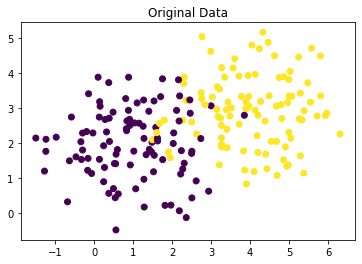

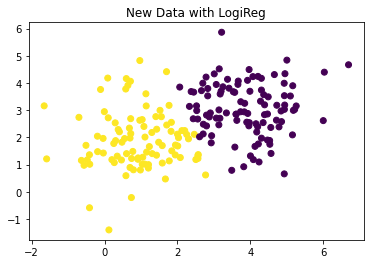

In [99]:
# Train my model
model = LogiReg(y,X)
model.fit()

# Fix X_test
X_test = np.column_stack((np.ones(len(y)),X_test))

# Predictions
probs = model.predict_prob(X_test)
labels = model.predict(X_test)

# Plot it
plt.scatter(X[:,0],X[:,1], c = y)
plt.title("Original Data")
plt.show()

plt.scatter(X_test[:,1],X_test[:,2], c = labels)
plt.title("New Data with LogiReg")
plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels`, and `sklearn`, train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [166]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )



In [160]:
# Statsmodel
sm.add_constant(X)
sm.add_constant(X_test)

start = time.time()

model = sm.Logit(y,X).fit_regularized(disp=0)
probs = model.predict(X_test)
model.summary()

labels = list(map(round, probs))

duration = time.time() - start

print("Statsmodel Accuracy: ", accuracy_score(y_test, labels))
print("Time: ", duration)

Statsmodel Accuracy:  0.96
Time:  0.05985593795776367


C:\Users\bryan\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\bryan\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [163]:
# ScikitLearn
start = time.time()
model = LogisticRegression(fit_intercept=True).fit(X,y)
labels = model.predict(X_test)
duration = time.time() - start

print("Scikit learn Accuracy: ", accuracy_score(y_test, labels))
print("Time: ", duration)

Scikit learn Accuracy:  0.96
Time:  0.009057998657226562


In [167]:
# My LogiReg
X_test = np.column_stack((np.ones(len(y)),X_test))

start = time.time()
model = LogiReg(y,X)
model.fit()

# probs = model.predict_prob(X_test)
labels = model.predict(X_test)

duration = time.time() - start

print("LogiReg Accuracy: ", accuracy_score(y_test, labels))
print("Time: ", duration)

LogiReg Accuracy:  0.915
Time:  7.149724006652832


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels.

In [157]:
def prob5():
    """Iris Dataset"""
    # Load the data
    data = datasets.load_iris()
    X = data.data[:,:2]
    y = data.target
    
    # Split it
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    # Train the model
    model = LogisticRegression(multi_class='multinomial', fit_intercept=True).fit(X_train, y_train)
    
    # Make predictions
    prediction_labels = model.predict(X_test)
    
    # Plot it
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
    plt.title("Actual X_test Data")
    plt.xlabel("Sepal Length")
    plt.ylabel("Sepal Width")
    plt.show()
    
    plt.scatter(X_test[:,0], X_test[:,1], c=prediction_labels)
    plt.title("Predicted X_test Data")
    plt.xlabel("Sepal Length")
    plt.ylabel("Sepal Width")
    plt.show()
    

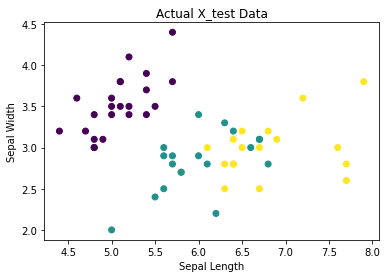

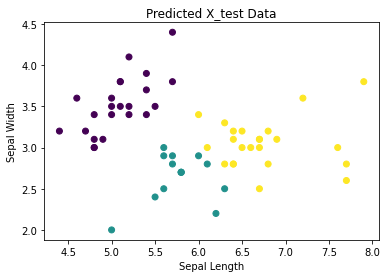

In [158]:
prob5()